In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df=pd.read_csv('Stationarity_3.csv')

In [3]:
df

,Date,Original,Value
0,2012-12-31,37.066559,0.000000
1,2013-01-01,37.417144,0.350585
2,2013-01-02,37.228052,-0.189092
3,2013-01-03,37.167616,-0.060436
4,2013-01-04,38.210898,1.043283
...,...,...,...
3648,2022-12-27,77.025000,1.281252
3649,2022-12-28,77.393750,0.368750
3650,2022-12-29,78.431249,1.037499
3651,2022-12-30,79.299999,0.868751


In [4]:
df.shape

(3653, 3)

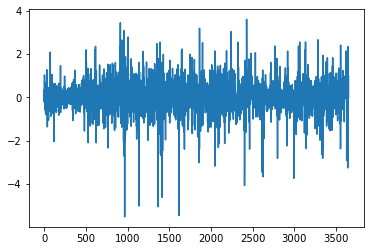

In [5]:
plt.plot(df['Value'])
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['value']=scaler.fit_transform(df[['Value']])

In [7]:
df

,Date,Original,Value,value
0,2012-12-31,37.066559,0.000000,0.604248
1,2013-01-01,37.417144,0.350585,0.642522
2,2013-01-02,37.228052,-0.189092,0.583604
3,2013-01-03,37.167616,-0.060436,0.597650
4,2013-01-04,38.210898,1.043283,0.718146
...,...,...,...,...
3648,2022-12-27,77.025000,1.281252,0.744126
3649,2022-12-28,77.393750,0.368750,0.644505
3650,2022-12-29,78.431249,1.037499,0.717515
3651,2022-12-30,79.299999,0.868751,0.699092


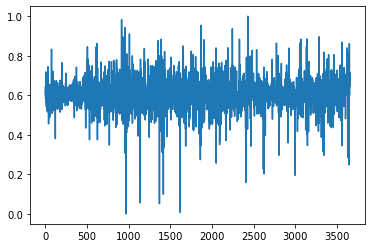

In [8]:
plt.plot(df['value'])
plt.show()

In [9]:
r_d=scaler.inverse_transform(np.array(df['value']).reshape(-1,1))

In [10]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers.convolutional import Conv1D,MaxPooling1D


to build the cnn model I am extracting features which is `lagged values` of 7 days 

that means we will predict 7 th value of the series using past 6 data

let us suppose a time series [1,2,3,4,3,5,6,7,8,4,3]

we need to calculate the value of 9 th term(9) that will depend on previous 6 terms. [4,3,5,6,7,8]


In [11]:
# let us build this function

def split_sequence(sequence,steps):
    x,y=list(),list()
    for start in range(len(sequence)):
        end_index=start+steps
        if end_index > len(sequence)-1:
            break;
        sequence_x,sequence_y=sequence[start:end_index],sequence[end_index]
        x.append(sequence_x)
        y.append(sequence_y)
    return array(x),array(y)

In [12]:
# let us test our function is working or not

s=[100,120,110,140,130,150,160,190,170,180]
steps=3 #let us take 3 lagged values for this 
x,y=split_sequence(s,steps)

print('______________________________________________')
print('original sequence :')
print(s)
print('______________________________________________')
print('lagged values :')
print(x)
print('______________________________________________')
print('observed values :')
print(y)

______________________________________________
original sequence :
[100, 120, 110, 140, 130, 150, 160, 190, 170, 180]
______________________________________________
lagged values :
[[100 120 110]
 [120 110 140]
 [110 140 130]
 [140 130 150]
 [130 150 160]
 [150 160 190]
 [160 190 170]]
______________________________________________
observed values :
[140 130 150 160 190 170 180]


In [13]:
# now do the same for our original data & 6 day lag

d=df['value'].tolist()

steps=6 
x,y=split_sequence(d,steps)


In [14]:
#reshape 2d data to 3d to fit in cnn
features=1
x=x.reshape((x.shape[0],x.shape[1],features))

print(x.shape)

(3647, 6, 1)


##### Defining CNN Model Architecture

We would be using “ReLu” as our activation function. 
We are adding Conv1D as our convolutional layer since we are dealing with a 
one-dimensional sequence. We then add the MaxPooling layer and Flatten layer
for pooling and flattening of the input matrix to be served as an input to 
the fully connected neural networks (100 neurons) to learn the pattern in 
our sequence. Lastly, we set one neuron for our output (Dense = 1). 
We will be using mean squared error as our loss function with 
Adam (Adaptive Moment Estimator)

In [15]:
# building the model

model=Sequential()
model.add(Conv1D(filters=128,kernel_size=2,activation='relu',input_shape=(steps,features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 128)            384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
____________________________________________________

In [17]:
#compiling the model

model.compile(optimizer='adam',loss='mse')

In [18]:
# fit model

model.fit(x,y,epochs=10000,verbose=0)

In [19]:
t_i1=array([0.304381189024771,0.301713307515281,0.301576848232958,0.290095456717525,0.295064792801103,0.289618173982269])
t_i1=t_i1.reshape(1,steps,features)
y_p1=model.predict(t_i1,verbose=0)
print(y_p1)

[[1.0078547]]


##### Forecasting
here i will take the data of last 100

In [20]:
test_data_x= x[-300:]
test_data_y= y[-300:]

In [21]:
test_data_pred=model.predict(test_data_x)

10/10 [==============================] - 0s 2ms/step


In [22]:
test_data_pred.shape

(300, 1)

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean = np.mean(test_data_pred)
abs_deviations = np.abs(test_data_pred-mean)
mad = np.mean(abs_deviations)
print("MAD:", mad)

mse = mean_squared_error(test_data_y,test_data_pred)
rmse = np.sqrt(mse)
print("RMSE :",rmse)


def mean_absolute_percentage_error(y_actual, y_predicted):
    return np.mean(np.abs((y_actual-y_predicted)/y_actual))*100

mape = mean_absolute_percentage_error(np.array(test_data_y), np.array(test_data_pred))
print("MAPE:", mape)


def mean_bias_error(y_actual, y_predicted):
    return mean_squared_error(y_actual,y_predicted)

mbe = mean_bias_error(np.array(test_data_y), np.array(test_data_pred))
print("MSE:", mbe)

MAD: 0.0319483
RMSE : 0.05795897390742106
MAPE: 11.878325914833933
MSE: 0.003359242656401115


In [24]:
from sklearn.metrics import r2_score

r2_score(test_data_y,test_data_pred)

0.47642629129393976

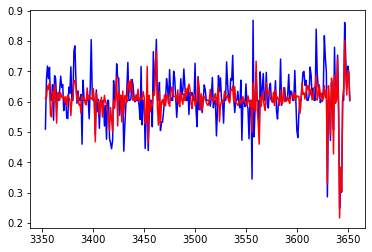

In [25]:
plt.plot(df.tail(300).index, test_data_y, color='blue')
plt.plot(df.tail(300).index, test_data_pred, color='red')
plt.show()

In [26]:
model.save_weights("model1.h5")

In [27]:
df.tail(1)

,Date,Original,Value,value
3652,2022-12-31,79.299999,0.0,0.604248


In [28]:
#function to increase date by 1

from datetime import datetime, timedelta

def increase(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    new_date_obj = date_obj + timedelta(days=1)
    formatted_date = datetime.strftime(new_date_obj, "%Y-%m-%d")
    return formatted_date 

start_date='2022-12-31'
increase(start_date)

'2023-01-01'

In [29]:
# forecasting 50 days future data

data=df['value'].tolist()
forecasted_df=pd.DataFrame(columns=['date','value'])
start_date='2022-12-31'

for i in range(50):
    new_date=increase(start_date)
    forecast_input=array(data[-6:])
    x_forecast=forecast_input.reshape(1,steps,features)
    forecasted_y=model.predict(x_forecast).item()
    #print(np.array(forecasted_y))
    #x=np.concatenate((x,np.array(x_forecast)))
    #y=np.concatenate((y,np.array([forecasted_y])))
    #model.fit(x,y,epochs=5,verbose=0)
    forecasted_df.at[i,'date']=new_date
    forecasted_df.at[i,'value']=forecasted_y
    data.append(forecasted_y)
    start_date=new_date

1/1 [==============================] - 0s 31ms/step


In [30]:
forecasted_df

,date,value
0,2023-01-01,0.525608
1,2023-01-02,0.573743
2,2023-01-03,0.596529
3,2023-01-04,0.613331
4,2023-01-05,0.604289
5,2023-01-06,0.62236
6,2023-01-07,0.633918
7,2023-01-08,0.603676
8,2023-01-09,0.615911
9,2023-01-10,0.621268


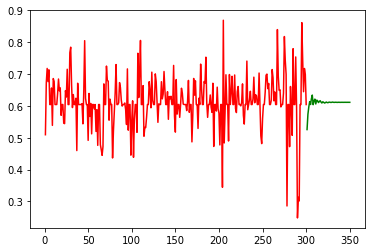

In [31]:
index_old=np.arange(1,301)
index_new=np.arange(301,351)

plt.plot(index_old, test_data_y, color='red')
plt.plot(index_new,forecasted_df['value'], color='green')

In [32]:
forcasted_dif=scaler.inverse_transform(np.array(forecasted_df['value']).reshape(-1,1))

In [33]:
dif_list=np.array(forcasted_dif).flatten().tolist()

dif_list

[-0.7203218931228074,
 -0.27941415931546715,
 -0.07070536577777595,
 0.08319617918735712,
 0.000379831076323686,
 0.16590606411157519,
 0.2717714191856083,
 -0.005237603432104291,
 0.10682773087000816,
 0.15589797858586876,
 0.016087245869546827,
 0.12348021118311553,
 0.11536935424296527,
 0.05630412416285246,
 0.08158449032849042,
 0.11084494178584188,
 0.0714524707340297,
 0.043673768451124126,
 0.0783643884011206,
 0.06638591497173875,
 0.04339751013046473,
 0.05276681653527885,
 0.07141916686533362,
 0.05738240515752106,
 0.05251731050258845,
 0.06675116559727459,
 0.06749149421943694,
 0.06109059984905987,
 0.06145312064929276,
 0.07016726898139684,
 0.06575587129181593,
 0.061037095273121886,
 0.06405791995337576,
 0.06566851688212126,
 0.06254122901505202,
 0.061810727763980326,
 0.06501881846001714,
 0.06377292619174689,
 0.06246097215114504,
 0.06332905659748583,
 0.06440078601142733,
 0.06355290227232843,
 0.06307299898406833,
 0.06405573609313338,
 0.06402407011961907,
 0.0

In [34]:
last_value=df.tail(1)['Original'].iloc[0]

last_value

#print(last_value+dif_list[1])

79.299999375

In [35]:
forecasted_og=[]

for i in range(len(dif_list)):
    n=last_value+dif_list[i]
    forecasted_og.append(n)
    last_value=n
    
forecasted_df['Retrive']=forecasted_og

In [36]:
forecasted_df

,date,value,Retrive
0,2023-01-01,0.525608,78.579677
1,2023-01-02,0.573743,78.300263
2,2023-01-03,0.596529,78.229558
3,2023-01-04,0.613331,78.312754
4,2023-01-05,0.604289,78.313134
5,2023-01-06,0.62236,78.479040
6,2023-01-07,0.633918,78.750811
7,2023-01-08,0.603676,78.745574
8,2023-01-09,0.615911,78.852402
9,2023-01-10,0.621268,79.008300


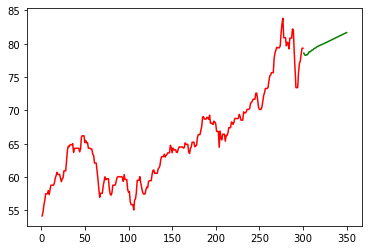

In [37]:
index_old=np.arange(1,301)
index_new=np.arange(301,351)

last_300 = df['Original'][-300:].tolist()

plt.plot(index_old, last_300, color='red')
plt.plot(index_new,forecasted_df['Retrive'], color='green')